# Inferencing Coarse Tuning Model

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

%matplotlib inline
import matplotlib.pyplot as plt

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from PIL import Image
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import matplotlib.cm as cm
from matplotlib.pyplot import subplots

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib

zsh:1: command not found: nvcc
torch:  2.0 ; cuda:  2.0.1
detectron2: 0.6


In [107]:
# Load trained model path
model_path = os.path.join("/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/coarse_tuning/output", "model_july_29.pth")  # path to the model we just trained

In [4]:
ROOT_DIR = "/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd"

MODEL_DATA_DIR = os.path.join(ROOT_DIR, "processed")

MODEL_TRAIN_DATA_DIR = os.path.join(MODEL_DATA_DIR,"train")
MODEL_VAL_DATA_DIR = os.path.join(MODEL_DATA_DIR,"val")
MODEL_TEST_DATA_DIR = os.path.join(MODEL_DATA_DIR,"test")

In [120]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("csd_train",)
cfg.DATASETS.TEST = ()
cfg.MODEL.DEVICE ="cpu"
cfg.DATALOADER.NUM_WORKERS = 4
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 10  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 10000 # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = model_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a custom testing threshold
predictor = DefaultPredictor(cfg)


[07/29 17:29:13 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/coarse_tuning/output/model_july_29.pth ...


In [68]:
from detectron2.structures import BoxMode

def get_csd_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = v["height"], v["width"]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            regions = anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]

            
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]
            category_dict = {"ND": 0, "LD": 1, "CD": 2, "RD": 3, "DD": 4}
            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": category_dict[regions["label"]],
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

## Validation

[ WARN:0@93813.819] global loadsave.cpp:244 findDecoder imread_('/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/processed/val/20200327-110127855643_cr22.jpg'): can't open/read file: check file path/integrity


/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/processed/val/20200714-152000049692_cr1409_augment0.jpg


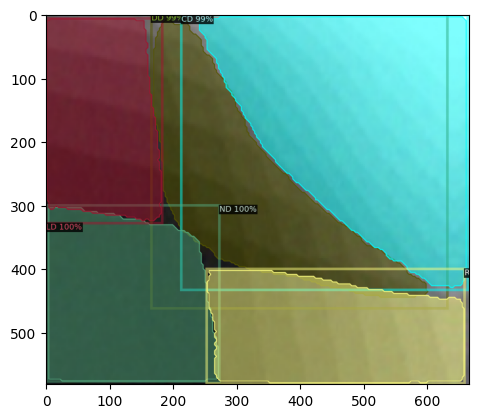

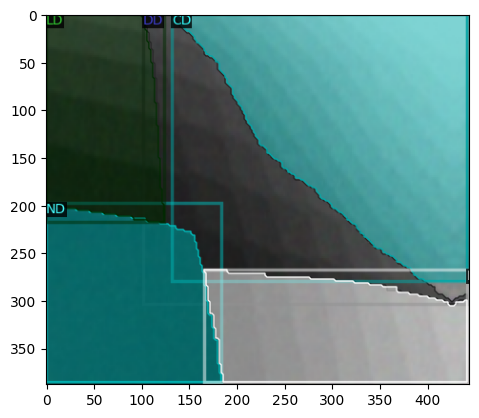

In [109]:
from detectron2.utils.visualizer import ColorMode

DatasetCatalog.clear()
MetadataCatalog.clear()

for d in ["train", "val", "test"]:
    DatasetCatalog.register("csd_" + d, lambda d=d: get_csd_dicts(os.path.join(MODEL_DATA_DIR,d)))
    MetadataCatalog.get("csd_" + d).set(thing_classes=["ND", "LD", "CD", "RD", "DD"])
    MetadataCatalog.get("csd_" + d).set(thing_colors=[(255,0,0),(0,255,0),(0,0,255)])

csd_metadata = MetadataCatalog.get("csd_val")

def check_image_exists(directory, image_name):
    # Get the list of files in the directory
    files = os.listdir(directory)

    # Check if the image_name exists with any image extension
    for file in files:
        if file == image_name:
            print(file, image_name)
            return True

    return False

dataset_dicts = get_csd_dicts(MODEL_VAL_DATA_DIR)
for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread("/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/csd/processed/val/20200327-110127855643_cr22.jpg")
    im = cv2.imread(d['file_name'])
    print(d['file_name'])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    v = Visualizer(im[:, :, ::-1],
                   metadata=csd_metadata, 
                   scale=3,    # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )

    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image())
    plt.show()
    
    plt.cla()
    plt.clf()
    plt.close()
    visualizer = Visualizer(im[:, :, ::-1], metadata=csd_metadata, scale=2)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1],cmap=cm.summer)
    plt.show()

## Experimental Test

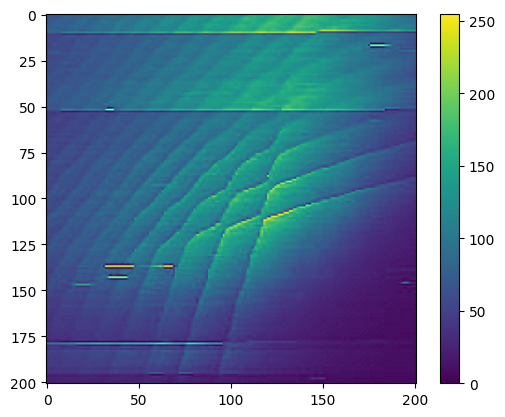

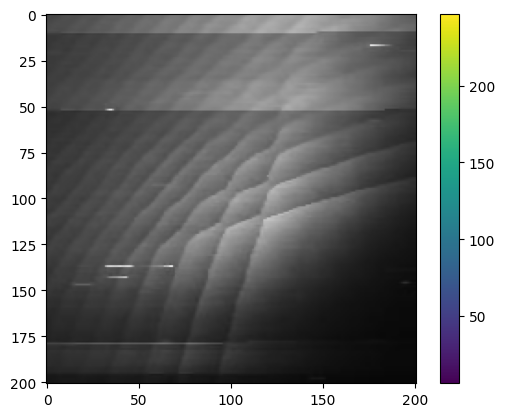

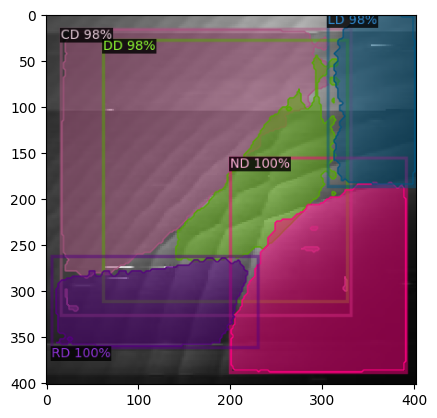

In [125]:
test_image = os.path.join(MODEL_TEST_DATA_DIR, "exp_large_10.jpg")
im = cv2.imread(test_image)
# im = cv2.rotate(im, cv2.ROTATE_180)
im_blur = cv2.bilateralFilter(im, 3,50,50)
gray = cv2.cvtColor(im_blur, cv2.COLOR_BGR2GRAY)
# Define the sharpening kernel (Laplacian)
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])

# Apply the kernel to the image using filter2D
sharpened_image = cv2.filter2D(gray, -1, kernel)

plt.imshow(sharpened_image)
plt.colorbar()
plt.show()

# sobelxy = cv2.Sobel(gray, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=3) # Combined X and Y Sobel Edge Detection
# plt.imshow(cv2.rotate(sobelxy.astype('uint8'), cv2.ROTATE_180))
# plt.colorbar()
# plt.show()


# im_adap_thres = cv2.adaptiveThreshold(sobelxy.astype('uint8'),255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
#  cv2.THRESH_BINARY_INV,21,25)

# # plt.imshow(im_thres)
# # plt.colorbar()
# # plt.show()
# # im = cv2.cvtColor(im_thres, cv2.COLOR_GRAY2RGB)
# # plt.imshow(im)
# # plt.colorbar()
# # plt.show()
# im = cv2.rotate(im_adap_thres, cv2.ROTATE_180)
# plt.imshow(im)
# plt.colorbar()
# plt.show()
# im = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)

# im = cv2.rotate(sobelxy.astype('uint8'), cv2.ROTATE_180)
im = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
# im = cv2.rotate(im, cv2.ROTATE_180)
plt.imshow(im)
plt.colorbar()
plt.show()
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
csd_metadata = MetadataCatalog.get("csd_test")
v = Visualizer(im[:, :, ::-1],
                metadata=csd_metadata, 
                scale=2,    # remove the colors of unsegmented pixels. This option is only available for segmentation models
)

out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image())

plt.show()